[<< back to main index](../README.md)

# Logistic Regression in Spark  - Credit Card Approval (Demo)

### Overview
Instructor to demo this on screen.
 
### Builds on
None

### Run time
approx. 20-30 minutes

### Notes

Spark has a logistic regression function called Logistic Regression.

## Step 1 : Load imports

In [1]:
# initialize Spark Session
import os
import sys
top_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
if top_dir not in sys.path:
    sys.path.append(top_dir)

from init_spark import init_spark
spark = init_spark()
spark

Initializing Spark...
Spark found in :  /home/ubuntu/spark
Spark config:
	 spark.app.name=TestApp
	spark.master=local[*]
	executor.memory=2g
	spark.sql.warehouse.dir=/tmp/tmpyyqk524j
	some_property=some_value
Spark UI running on port 4041


## Step 2 : Sigmoid Curve

In logistic regression, we often use a sigmoid activation function.  Let's generate a sigmoid curve in python!  (no spark required!)

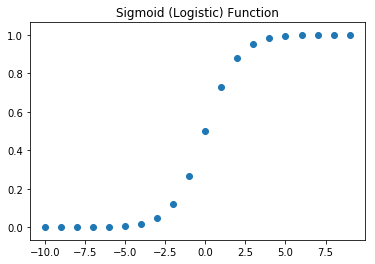

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

# plot sigmoid curve
x = np.arange(-10.,10.,1.)
b = 0 # intercept
m = 1 # slope
sigmoid = lambda x,b,m: np.exp((b + m*x)) / (1 + np.exp((b + m*x)))
y = sigmoid(x,b,m)

## hint : scatter (x,y)
plt.scatter(x,y) 
plt.title("Sigmoid (Logistic) Function")
plt.show()


## Step 3: Credit Approval Data

Here is the sample data we are looking at:

| score | approved | 
|-------|----------| 
| 550   | 0        | 
| 750   | 1        | 
| 680   | 1        | 
| 650   | 0        | 
| 450   | 0        | 
| 800   | 1        | 
| 775   | 1        | 
| 525   | 0        | 
| 620   | 0        | 
| 705   | 0        | 
| 830   | 1        | 
| 610   | 1        | 
| 690   | 0        | 


## Step 4: Let's visualize the data

In [3]:
import pandas as pd

credit_approval = pd.DataFrame({'score' : [550., 750., 680., 650., 450., 800., 775., 525., 620., 705., 830., 610., 690.],
              'approved' : [0,1,1,0,0,1,1,0,0,0,1,1,0]
             })

credit_approval

,score,approved
0,550.0,0
1,750.0,1
2,680.0,1
3,650.0,0
4,450.0,0
5,800.0,1
6,775.0,1
7,525.0,0
8,620.0,0
9,705.0,0


## Step 5: Let us plot and visualize the sample data.

**=> Run a scatterplot with score on the X axis and approved on the y axis**

Text(0, 0.5, 'approved')

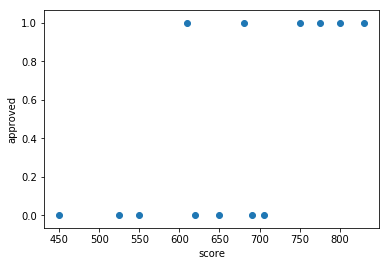

In [4]:
## Hint x = credit_approval.score,   y = credit_approval.approved
plt.scatter(credit_approval.score,credit_approval.approved)
plt.xlabel('score')
plt.ylabel('approved')

## Step 6: Convert dataframe to Spark and Prepare feature vector

We need to first convert the pandas dataframe to a spark dataframe, and then prepare the feature vector. To create the feature vector, we use the VectorAssembler.

**=> Run VectorAssembler by using input column as "score"**

We will need a numeric column called "label" in our dataset because our model by default will look for a column by that name.  So, we'll just add it.

**=> Create columnn 'label' as "approved"**




In [5]:
from pyspark.ml.feature import VectorAssembler

df = spark.createDataFrame(credit_approval)
## Hint : inputCols = ["score"]
assembler = VectorAssembler(inputCols=["score"], outputCol="features")
featureVector = assembler.transform(df)
featureVector.show()
## Hint : featureVector["approved"]
featureVector = featureVector.withColumn("label",featureVector["approved"])
featureVector.show()


+-----+--------+--------+
|score|approved|features|
+-----+--------+--------+
|550.0|       0| [550.0]|
|750.0|       1| [750.0]|
|680.0|       1| [680.0]|
|650.0|       0| [650.0]|
|450.0|       0| [450.0]|
|800.0|       1| [800.0]|
|775.0|       1| [775.0]|
|525.0|       0| [525.0]|
|620.0|       0| [620.0]|
|705.0|       0| [705.0]|
|830.0|       1| [830.0]|
|610.0|       1| [610.0]|
|690.0|       0| [690.0]|
+-----+--------+--------+

+-----+--------+--------+-----+
|score|approved|features|label|
+-----+--------+--------+-----+
|550.0|       0| [550.0]|    0|
|750.0|       1| [750.0]|    1|
|680.0|       1| [680.0]|    1|
|650.0|       0| [650.0]|    0|
|450.0|       0| [450.0]|    0|
|800.0|       1| [800.0]|    1|
|775.0|       1| [775.0]|    1|
|525.0|       0| [525.0]|    0|
|620.0|       0| [620.0]|    0|
|705.0|       0| [705.0]|    0|
|830.0|       1| [830.0]|    1|
|610.0|       1| [610.0]|    1|
|690.0|       0| [690.0]|    0|
+-----+--------+--------+-----+




## Step 7: Fit logistic regression

Now it's time to fit our logistic regression model.  This is a linear model, so we will be getting the coefficients and intercept.


In [13]:
from pyspark.ml.classification import LogisticRegression

## TODO : set max Iter to 10

#lr = LogisticRegression(maxIter=???)
## TODO : you can try this with regularization parameters
lr = LogisticRegression(maxIter=100, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(featureVector)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [0.002320489931703392]
Intercept: -1.6982871525249927


In [15]:
lrModel.summary.predictions.show()

+-----+--------+--------+-----+--------------------+--------------------+----------+
|score|approved|features|label|       rawPrediction|         probability|prediction|
+-----+--------+--------+-----+--------------------+--------------------+----------+
|550.0|       0| [550.0]|  0.0|[0.42201769008812...|[0.60396596442825...|       0.0|
|750.0|       1| [750.0]|  1.0|[-0.0420802962525...|[0.48948147803162...|       1.0|
|680.0|       1| [680.0]|  1.0|[0.12035399896668...|[0.53005223273397...|       0.0|
|650.0|       0| [650.0]|  0.0|[0.18996869691778...|[0.54734986256583...|       0.0|
|450.0|       0| [450.0]|  0.0|[0.65406668325846...|[0.65792629442028...|       0.0|
|800.0|       1| [800.0]|  1.0|[-0.1581047928377...|[0.46055593326974...|       1.0|
|775.0|       1| [775.0]|  1.0|[-0.1000925445451...|[0.47499773418221...|       1.0|
|525.0|       0| [525.0]|  0.0|[0.48002993838071...|[0.61775494425696...|       0.0|
|620.0|       0| [620.0]|  0.0|[0.25958339486888...|[0.5645338782

The output lists approval & estimated probabilities

## Step 8 : Evaluate The Model


### 8.1 Confusion Matrix
**=> TODO : Can you interpret the confusion matrix?**

In [16]:
lrModel.summary.predictions.groupBy('approved').pivot('prediction').count().na.fill(0).orderBy('approved').show()

+--------+---+---+
|approved|0.0|1.0|
+--------+---+---+
|       0|  7|  0|
|       1|  2|  4|
+--------+---+---+



### 8.2 : ROC curve and AUC (Area Under Curve)

**=> TODO: What is the meaning of the ROC curve?  How is the AUC calculated?**

In [17]:

# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = lrModel.summary

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " ,  trainingSummary.areaUnderROC)



areaUnderROC:  0.8571428571428571


         FPR       TPR
0   0.000000  0.000000
1   0.000000  0.166667
2   0.000000  0.333333
3   0.000000  0.500000
4   0.000000  0.666667
5   0.142857  0.666667
6   0.285714  0.666667
7   0.285714  0.833333
8   0.428571  0.833333
9   0.571429  0.833333
10  0.571429  1.000000
11  0.714286  1.000000
12  0.857143  1.000000
13  1.000000  1.000000
14  1.000000  1.000000


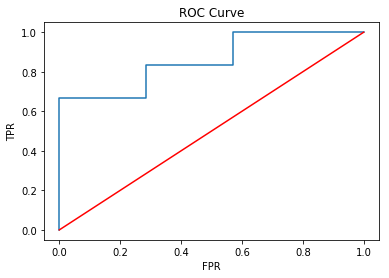

In [18]:
# ROC

roc_df = trainingSummary.roc.toPandas()
print(roc_df)

plt.plot(roc_df['FPR'], roc_df['TPR'])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.plot([0.0, 1.0], [0.0, 1.0], 'r')

**How many iterations did it take?
Did the model converge before our specified MAX itertions?
What can we learn from this?
**

In [19]:
trainingSummary.totalIterations

101

In [20]:
## Some experimentations

print ("total iterations ", trainingSummary.totalIterations)

## Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
i = 0
for objective in trainingSummary.objectiveHistory:
    i = i+1
    print(i, " : ",  objective)


total iterations  101
objectiveHistory:
1  :  0.6901856760188043
2  :  0.6899327462112604
3  :  0.6898596572878024
4  :  0.6897755898678963
5  :  0.6890411819005514
6  :  0.6877422034867856
7  :  0.6868231380259231
8  :  0.6866303048864236
9  :  0.6860730569628928
10  :  0.6858904394799108
11  :  0.6853725490572904
12  :  0.685202300841395
13  :  0.6847279476152178
14  :  0.6845723649621482
15  :  0.684155360503761
16  :  0.6840549499644968
17  :  0.6838079689009933
18  :  0.6833076139949844
19  :  0.6828771886534204
20  :  0.6827319195897444
21  :  0.6822223137622867
22  :  0.6820084453276453
23  :  0.6819798414717818
24  :  0.6818293410775397
25  :  0.6817742619549414
26  :  0.6816740732601034
27  :  0.6815995372752527
28  :  0.6815391542558873
29  :  0.6814508416788901
30  :  0.6814216175324126
31  :  0.6813241122773623
32  :  0.6812913832645463
33  :  0.6809472189020087
34  :  0.6805084514178277
35  :  0.6805084482544512
36  :  0.6805084451142253
37  :  0.6805084426651972
38  :  0.

** Q : increase the maxIterations to 100 (in step 3) and re-run again**  
Does the accuracy improve?

## Step 9: Visualize data and logit model

Let's visualize the data and our model.

Text(0, 0.5, 'approved')

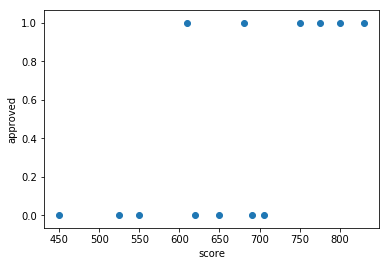

In [21]:
plt.scatter(credit_approval.score, credit_approval.approved)
plt.xlabel('score')
plt.ylabel('approved')


## Step 10: Let's create some new test data and make predictions

In [22]:
newdata = pd.DataFrame({'score' : [600., 700., 750, 800.]
             })
print(newdata)

spark_newdata = spark.createDataFrame(newdata)
newfeatures = assembler.transform(spark_newdata)
lrModel.transform(newfeatures).show()

   score
0  600.0
1  700.0
2  750.0
3  800.0
+-----+--------+--------------------+--------------------+----------+
|score|features|       rawPrediction|         probability|prediction|
+-----+--------+--------------------+--------------------+----------+
|600.0| [600.0]|[0.30599319350295...|[0.57590694504138...|       0.0|
|700.0| [700.0]|[0.07394420033261...|[0.51847763160250...|       0.0|
|750.0| [750.0]|[-0.0420802962525...|[0.48948147803162...|       1.0|
|800.0| [800.0]|[-0.1581047928377...|[0.46055593326974...|       1.0|
+-----+--------+--------------------+--------------------+----------+

